:::{index} single: Scenarios; Impact Decomposition
:::
:::{index} single: Impact Decomposition; 
:::


In [1]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')


In [2]:
%load_ext autoreload
%autoreload 2


# Analyzing the impact of a shock 

When working with a model, it is often useful to have a quantitative of the contribution of different channels to a final result.  For example, an increase in interest rates will tend to reduce investment and consumer demand -- contributing to a reduction in GDP. At the same time, lower inflation as the higher interest rate takes effect will tend to work in the opposite direction. 

The `tracedep()` and `tracepre()` methods introduced in the previous chapter give a sense of impacts. The `modelflow` methods `.dekomp()` and `.totdif()` take that one step further by calculating the contribution of each channel to the overall result.



In [3]:
# Prepare the notebook for use of modelflow 

# Jupyter magic command to improve the display of charts in the Notebook
%matplotlib inline

# Import pandas 
import pandas as pd

# Import the model class from the modelclass module 
from modelclass import model 

# functions that improve rendering of modelflow outputs
model.widescreen()
model.scroll_off();

<IPython.core.display.Javascript object>

In [4]:
# set default precision 
pd.set_option("display.precision", 2)

In [5]:
# For display reasons 
latex = 1

## Load the existing model, data and descriptions 
The file `pak.pcim` contains a dump of model equations, dataframe, simulation options and variable descriptions for the World Bank climate aware model for Pakistan described in {cite:t}`burns_climate_2021`. 

The code below:

 - Loads the model and simulates it using the `DataFrame` stored in the `pcim` file to establish a baseline.
 - Creates a `DataFrame` that is a copy (from 2020) of the active solution in `mpak` and changes the tax rate to 30 USD/Ton for carbon emissions from coal, oil and natural gas.
 - Runs a simulations with these new carbon taxes. 
 
The results from this simulation will be used below to explore the attribution functionality of modelflow.
  

In [6]:
mpak,baseline = model.modelload('../models/pak.pcim',alfa=0.7,run=1,keep='Business as Usual')
alternative  =  baseline.upd("<2020 2100> PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER = 30")

#simulate the model
result = mpak(alternative,2025,2100,keep='Carbon tax nominal 30',
              ljit=False,         # do not compile the model (default value for this option)
              nfirst=800,
              maxiteration=100   # if no convergence after 100 iterations - stop
             ) # simulates the model 

file read:  ..\models\pak.pcim



:::{index} single: Impact Decomposition; Single Equation
:::


## The mathematics of decomposition

At its root the idea of attribution is to take the total derivative of the model to identify the sensitivity of the equation of interest to changes elsewhere in the model and then combine that with the changes in other variables. 

Take a variable y that is a function of two other variables a and b.  In the model, the relationship might be written as:


$y = f(a,b)$

If there are two sets of results designated with a subscript 0 and 1, these can be written as: 

\begin{eqnarray}
y_0 = f(a_0,b_0)\\
y_1 = f(a_1,b_1)
\end{eqnarray}

If the change in the three variables is specified as $\Delta y, \Delta a, \Delta b$, the total derivative of y can be written as:


$\Delta y = \underbrace{\Delta a \dfrac{\partial {f}}{\partial{a}}(a,b)}_{\Omega a} + 
\underbrace{\Delta b \dfrac{\partial {f}}{\partial{b}}(a,b)}_{\Omega b}+Residual$

The first expression can be called $\Omega_a$ or the contribution of changes in a to changes in y, and the second $\Omega_b$,  or the contribution of changes in b to changes in y.  


`Modelflow` performs a numerical approximation of $\Omega_a$ and $\Omega_b$ by performing two runs of the $f()$:

\begin{eqnarray}  
y_0&=&f(a_{0},b_{0}) \\
y_1&=&f(a_0+\Delta a,b_{0}+ \Delta b)
\end{eqnarray}

and calculates $\Omega_a$ and $\Omega_b$ as:

\begin{eqnarray}  
\Omega a&=&f(a_1,b_1 )-f(a_1-\Delta a,b_1) \\
\Omega b&=&f(a_1,b_1 )-f(a_1,b_1-\Delta  b)
\end{eqnarray}



And: 

\begin{eqnarray}
residual = \Omega a + \Omega b -(y_1 - y_0) 
\end{eqnarray}

If the model is fairly linear, the residual will be small. 



## Model-level decomposition or  single equation decomposition?

Above, the relationship between y, a, and b was summarized by the function f(). 

$f(a,b)$ could represent **a single equation** in the model or it could represent **the entire model**. 

In the **single equation** mode, $\Delta a$ and $\Delta b$ would be treated as exogenous variables in the attribution calculation as they are both on the right hand side of the equation (i.e. exogenous to this equation -- even if they might be endogenous variables in some other equation). Here results will show the direct impact of changes in the RHS variable(s) on the LHS variable.

When analyzing the total derivative for the **entire model** instance, $a$ and $b$ will be purely exogenous variables. In this case, the decomposition shows the cumulative effect -- potentially operating through multiple channels of a change in the exogenous (or exogenized variables) on different endogenous variables in the model. Say we are looking at inflation, an exogenous change in wages would influence prices directly through higher costs of production and indirectly by inducing higher demand.  The  model-level decompoistion will return the sum of the two or more influences.

Assume the simple equation example such that  $a$ and $b$ are simple variables. When $\Delta y$, $\Delta a$ and $\Delta b$ reflect the difference across scenarios (say the value of the three variables in `.lastdf` less the value in `.basedf`) then;

$\Omega_a$, $\Omega_b$ are the absolute contribution of a and b to the change in y, and 
$100*\bigg[\cfrac{\Omega_a}{\Delta y}\bigg]$ is the share of the change in y explained by expressed as a percent and  $100*\bigg[\cfrac{\Omega_b}{\Delta y}\bigg]$ is the share of the change in y explained by b expressed as a percent.

If $\Delta y$, $\Delta a$ and $\Delta b$ are the changes over time ($\Delta y_t=y_t-y_{t-1}$), then $\Omega_a$, $\Omega_b$ are the contributions of a and b to the rate of growth of y, while $100*\bigg[\cfrac{\Omega_a}{\Delta y_{t-1}}\bigg]$  $100*\bigg[\cfrac{\Omega_b}{\Delta y_{t-1}}\bigg]$ are are the contributions of a and b to the rate of growth of y.


:::{index} single: Impact Decomposition; Single equation 
:::

## Decomposing the source of changes to a single endogenous variable

The `modelflow` method `.dekomp()` is used to calculate the contribution of RHS variables to the change in an endogenous (LHS) variable. 

This method takes advantage of the fact that the model object stores the initial and most recent simulation result in two dataframes called `.basedf` and `.lastdf`, as well as all of the equations of the model. 



The `dekomp()` method calculates the contribution to changes in the level of the dependent variable in a given equation. It does not calculate what caused the changes to the RHS variables.

In the example below, the contribution to the change in Total emissions is decomposed into the contribution from each of three sources in the model, the consumption of Crude Oil, Natural Gas and Coal.  As the equation for total emissions is just the sum of the three this is a fairly trivial decomposition, but it provides an easily understood illustration of the process at work.

Note that, initially some carbon taxes were negative because the associated energy products benefited from some sort of subsidy.  As a result, although each carbon tax is set to 30 in the simulation that was run earlier, the change in the levels of the Carbon tax is different across carbon taxes, with the increase in the net taxation on the carbon emissions from natural gas being particularly large.  


In [7]:
with mpak.set_smpl(2023,2030):
    print(mpak['PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER'].dif.rename().df)

      Carbon tax on coal (USD/t)  Carbon tax on gas (USD/t)  \
2023                       35.55                       71.0   
2024                       35.55                       71.0   
2025                       35.55                       71.0   
2026                       35.55                       71.0   
2027                       35.55                       71.0   
2028                       35.55                       71.0   
2029                       35.55                       71.0   
2030                       35.55                       71.0   

      Carbon tax on oil (USD/t)  
2023                      38.71  
2024                      38.71  
2025                      38.71  
2026                      38.71  
2027                      38.71  
2028                      38.71  
2029                      38.71  
2030                      38.71  


In [8]:
dekomp_result = mpak.PAKCCEMISCO2TKN.dekomp(start=2024,end=2027);


Formula        : FRML <IDENT> PAKCCEMISCO2TKN = PAKCCEMISCO2CKN+PAKCCEMISCO2OKN+PAKCCEMISCO2GKN $ 

                        2024         2025         2026         2027
Variable    lag                                                    
Base        0   230370295.21 236240660.30 242537405.72 248995660.74
Alternative 0   230370295.21 183872960.05 190234949.52 196979002.71
Difference  0           0.00 -52367700.25 -52302456.20 -52016658.03
Percent     0          -0.00       -22.17       -21.56       -20.89

 Contributions to differende for  PAKCCEMISCO2TKN
                          2024         2025         2026         2027
Variable        lag                                                  
PAKCCEMISCO2CKN 0         0.00 -22807768.85 -22763630.18 -22643891.82
PAKCCEMISCO2OKN 0         0.00 -13105358.99 -13576627.91 -13868111.85
PAKCCEMISCO2GKN 0         0.00 -16454572.41 -15962198.11 -15504654.36

 Share of contributions to differende for  PAKCCEMISCO2TKN
                     2024     

:::{index} single: Impact Decomposition; Equations, output as tables
:::


The above results from the call to `.dekomp()` are presented in several sections.

|Section|Table|Contents|
|:--|:--|:--|
|**The first section**| |the normalized formula of the RHS variable `PAKCCEMISCO2TKN`|
|**The second section**| |Shows the changes in level terms. |
|| diff_level |First by showing the results of the simulation **base**, then the previous level **last**, then the difference and then the difference expressed as a percent|
|| att_level |This is followed by a table showing the contribution of the changes in every LHS variable to the observed change in the dependent variable.|
|**The third section**| att_pct |Shows the same results for the RHS variables, but expressed as a percent of the total change in the dependent variable. |
|**The fourth section**|| Shows the same results but for the change in the growth rate of the dependent variable.|
|| diff_growth |The first table shows the post-shock growth rate of the dependent variable from the `.lastdf` dataframe, followed by the pre-shock growth rate and the difference in the growth rates. |
|| att_growth |The second table of this section shows the contribution to the change in the growth rate from each RHS variable. |


The object returned by `.dekomp()` is a [namedtuple](https://realpython.com/python-namedtuple/) that contains each of these tables which can then be referred to later.

The code below extracts the different sub-components of the `.dekomp()` results and displays them individually.



In [9]:
# Loop over the elements in the result of dekomp. 
# a named tuple can be used both as a straight tuple and the elements
# can be accessed through the field name. 

for f,df in zip(dekomp_result._fields,dekomp_result):
    display(f)
    display(df)
    

'diff_level'

,,2024,2025,2026,2027
Variable,lag,,,,
Base,0,230370295.21,236240660.3,242537405.72,248995660.74
Alternative,0,230370295.21,183872960.05,190234949.52,196979002.71
Difference,0,0.0,-52367700.25,-52302456.2,-52016658.03
Percent,0,-0.0,-22.17,-21.56,-20.89


'att_level'

,,2024,2025,2026,2027
Variable,lag,,,,
PAKCCEMISCO2CKN,0,0.0,-22807768.85,-22763630.18,-22643891.82
PAKCCEMISCO2OKN,0,0.0,-13105358.99,-13576627.91,-13868111.85
PAKCCEMISCO2GKN,0,0.0,-16454572.41,-15962198.11,-15504654.36


'att_pct'

,,2024,2025,2026,2027
Variable,lag,,,,
PAKCCEMISCO2CKN,0,NaN,4.36e+01,43.52,43.53
PAKCCEMISCO2GKN,0,NaN,3.14e+01,30.52,29.81
PAKCCEMISCO2OKN,0,NaN,2.50e+01,25.96,26.66
Total,0,0.0,1.00e+02,100.00,100.00
Residual,0,-100.0,5.68e-14,0.00,0.00


'diff_growth'

,,2024,2025,2026,2027
Variable,lag,,,,
Base,0,2.27,2.55,2.67,2.66
Alternative,0,2.27,-20.18,3.46,3.55
Difference,0,0.0,-22.73,0.79,0.88


'att_growth'

,,2024,2025,2026,2027
Variable,lag,,,,
PAKCCEMISCO2CKN,0,0.0,-9.9,-12.38,-11.9
PAKCCEMISCO2OKN,0,0.0,-5.69,-7.38,-7.29
PAKCCEMISCO2GKN,0,0.0,-7.14,-8.68,-8.15
Total,0,0.0,-22.73,-28.44,-27.34
Residual,0,0.0,-0.0,-29.24,-28.23


## A more complex example

The above decomposition is fairly straight forward because the decomposed equation is a simple identity, where Total Emissions are just the sum of its three component parts: Total Carbon emissions = Emissions from Oil+  Emissions from Coal + Emissions from Natural Gas.

The following single-equation decomposition looks to the impact of the same shock (introduction of a carbon tax) on a different variable (inflation).  The inflation equation is more complex and has more direct causal variables, so the decomposition is more interesting.

Recall the inflation equation is given by the `.frml` method for its normalized version and `.eviews` for its original specification.  The equation for the consumer price level (PAKNECONPRVTXN) was originally specified in eviews as:

In [10]:
mpak['PAKNECONPRVTXN'].eviews

PAKNECONPRVTXN : 
@IDENTITY PAKNECONPRVTXN  = ((PAKNECONENGYSH^PAKCESENGYCON)  * PAKNECONENGYXN^(1  - PAKCESENGYCON)  + (PAKNECONOTHRSH^PAKCESENGYCON)  * PAKNECONOTHRXN^(1  - PAKCESENGYCON))^(1  / (1  - PAKCESENGYCON))


The normalized equation is given by `mpak['PAKNECONPRVTXN'].frml`.  

Note in the Pakistan model, consumer inflation is derived as a constant elasticity of transformation (CET) aggregation of the price of energy goods(PAKNECONENGYXN) and non-energy goods (PAKNECONOTHRXN).

In [11]:
mpak['PAKNECONPRVTXN'].frml

PAKNECONPRVTXN : FRML <IDENT> PAKNECONPRVTXN = ((PAKNECONENGYSH**PAKCESENGYCON)*PAKNECONENGYXN**(1-PAKCESENGYCON)+(PAKNECONOTHRSH**PAKCESENGYCON)*PAKNECONOTHRXN**(1-PAKCESENGYCON))**(1/(1-PAKCESENGYCON)) $


Note further the  equation is solving for the **level** of the price deflator -- not inflation which is the rate of growth of this index.

Because the equation solves for the level of the price deflator, the decomposition show the contributions of each explanatory variable to the increase in the price level (not that of the inflation rate). However, the 4th table is showing the impacts on the rate of growth of the price level -- i.e. the level of inflation.

In [12]:
mpak['PAKNECONPRVTXN'].dekomp(start=2020,end=2024);


Formula        : FRML <IDENT> PAKNECONPRVTXN = ((PAKNECONENGYSH**PAKCESENGYCON)*PAKNECONENGYXN**(1-PAKCESENGYCON)+(PAKNECONOTHRSH**PAKCESENGYCON)*PAKNECONOTHRXN**(1-PAKCESENGYCON))**(1/(1-PAKCESENGYCON)) $ 

                      2020       2021       2022       2023       2024
Variable    lag                                                       
Base        0         1.67       1.82       1.98       2.14       2.30
Alternative 0         1.67       1.82       1.98       2.14       2.30
Difference  0         0.00       0.00       0.00       0.00       0.00
Percent     0        -0.00      -0.00      -0.00      -0.00      -0.00

 Contributions to differende for  PAKNECONPRVTXN
                         2020       2021       2022       2023       2024
Variable       lag                                                       
PAKNECONENGYSH 0         0.00       0.00       0.00       0.00       0.00
PAKCESENGYCON  0         0.00       0.00       0.00       0.00       0.00
PAKNECONENGYXN 0   

Interestingly only 25% of the increase in the price level each period is due to the direct channel (the impact on the price of energy consumed by households), the bulk of the increase comes indirectly through other prices.  Indeed as time progresses this share rises from 77% in the first year of the price change (2020) to 86% by 2024.

### Non-energy prices

Below is the formula for nonenergy consumer prices and their decomposition. This equation is written out as a more standard augmented-phillips-curve type inflation equation reflecting changes in the cost of local goods production (PAKNYGDPFCSTXN), Government taxes on goods and services (PAKGGREVGNFSXN), the price of imports (PAKNEIMPGNGSXN) and the influence of the economic cycle (PAKNYGDPGAP_) on the price level.

In [13]:
mpak['PAKNECONOTHRXN'].eviews

PAKNECONOTHRXN : 
DLOG(PAKNECONOTHRXN) = 0.590372627657176*DLOG(PAKNYGDPFCSTXN) + D(PAKGGREVGNFSXN/100) + (1 - 0.590372627657176)*DLOG(PAKNEIMPGNFSXN) + 0.2*PAKNYGDPGAP_/100


In [14]:
mpak['PAKNECONOTHRXN'].dekomp(start=2025,end=2029);


Formula        : FRML <DAMP,STOC> PAKNECONOTHRXN = (PAKNECONOTHRXN(-1)*EXP(PAKNECONOTHRXN_A+ (0.590372627657176*((LOG(PAKNYGDPFCSTXN))-(LOG(PAKNYGDPFCSTXN(-1))))+((PAKGGREVGNFSXN/100)-(PAKGGREVGNFSXN(-1)/100))+(1-0.590372627657176)*((LOG(PAKNEIMPGNFSXN))-(LOG(PAKNEIMPGNFSXN(-1))))+0.2*PAKNYGDPGAP_/100) )) * (1-PAKNECONOTHRXN_D)+ PAKNECONOTHRXN_X*PAKNECONOTHRXN_D  $ 

                      2025       2026       2027       2028       2029
Variable    lag                                                       
Base        0         2.50       2.65       2.81       2.96       3.11
Alternative 0         2.55       2.71       2.87       3.03       3.19
Difference  0         0.05       0.06       0.07       0.08       0.08
Percent     0         1.95       2.26       2.47       2.61       2.65

 Contributions to differende for  PAKNECONOTHRXN
                           2025       2026       2027       2028       2029
Variable         lag                                                       
P

These results indicate that much of the initial impact on prices is coming from the increase in the price of imported goods (which includes a large fuel component). As time progresses, the imported inflation component declines (because fuel and import prices are no longer rising) and the lagged consumption price dominates (the level this period is basically determined by the price level in the previous period) .  Other factors such as the cost of domestically produced goods play a larger role and the net impact of imported prices (the total of the contemporaneous and lagged value) approaches zero. Cyclical pressure are initially adding to inflation before declining and eventually turning negative. 

:::{index} single: Impact Decomposition; Equations, .get_attr() more output transformations 
:::

## The `get_att()` method provides more control over the outputs of `.dekomp()`

Following a call to the `.dekomp()` method, the `.get_att()` method provides a range of mechanisms that allow the results to be displayed in different ways.




### The default display of `.get_att()` 

By default `.get_att()` displays the share contributions of RHS variables to the total change in the LHS variable.  The start= and end= options allow the period for which results are displayed to be restricted.



In [15]:

mpak.PAKNECONPRVTKN.get_att(start=2025,end=2035)

,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035
Percent att.,,,,,,,,,,,
PAKNECONPRVTXN,131%,118%,109%,98%,89%,84%,89%,88%,89%,90%,93%
PAKNECONPRVTKN(-1),0%,66%,69%,69%,73%,76%,75%,86%,87%,88%,89%
PAKNYYWBTOTLCN(-1),0%,15%,25%,31%,32%,33%,32%,56%,59%,63%,67%
PAKBXFSTREMTCD(-1),0%,10%,11%,10%,9%,8%,7%,8%,8%,8%,9%
PAKGGEXPTRNSCN(-1),0%,1%,1%,1%,1%,2%,2%,2%,2%,2%,3%
PAKPANUSATLS,1%,1%,1%,1%,1%,1%,1%,1%,1%,1%,1%
PAKBMFSTREMTCD,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
PAKGGREVDRCTXN(-1),0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
PAKNECONPRVTKN_A,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%


```{image} Attrib-get_att.png
    :alt: get attribution 
    :class: bg-primary mb-1
    :width: 100%
    :align: center
```    

:::{index} single: Impact Decomposition; Single equation, impact accumulated across lags 
:::

### Options: Lag=True/False 

Because the decomposition of the equation is based on the normalized (levelized) version of the equation, for equations initially written as growth rates or ECMs many variables will occur several times in the attribution table with both the contribution of the current value of the variable and those of any lagged versions that appear in the normalized equation.

The `Lag=False` option changes the default behaviour of `.get_att()` and aggregates the contributions of different lags.

By aggregating the lags, the net effect of changes in the variables can be more easily determined. Below it is clearer that the initial impact of higher import prices drove most of the inflation response.  In subsequent periods, import prices were stable or even falling so most of the contribution to the change in the level of other goods inflation was from the lagged dependent variable and the changed state of the economic cycle (the Gap variable which initially was adding to inflationary pressures eventually subtracts from inflation as the economy slows).


In [16]:
mpak.PAKNECONOTHRXN.get_att(lag=False,start=2025,end=2035)

,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035
Percent att.,,,,,,,,,,,
PAKGGREVGNFSXN,-0%,-0%,-0%,-0%,-0%,-0%,-0%,-0%,-0%,-0%,-0%
PAKNECONOTHRXN,-0%,87%,91%,95%,98%,101%,86%,108%,109%,109%,109%
PAKNECONOTHRXN_A,-0%,-0%,-0%,-0%,-0%,-0%,-0%,-0%,-0%,-0%,-0%
PAKNECONOTHRXN_D,-0%,-0%,-0%,-0%,-0%,-0%,-0%,-0%,-0%,-0%,-0%
PAKNECONOTHRXN_X,-0%,-0%,-0%,-0%,-0%,-0%,-0%,-0%,-0%,-0%,-0%
PAKNEIMPGNFSXN,95%,-4%,-4%,-4%,-4%,-4%,-3%,-4%,-4%,-4%,-4%
PAKNYGDPFCSTXN,1%,11%,7%,5%,3%,2%,11%,-3%,-3%,-4%,-4%
PAKNYGDPGAP_,4%,6%,4%,3%,1%,0%,-3%,-3%,-3%,-2%,-2%


```{image} Attrib-get_att.png
    :alt: Menu to start notebooks in subfolders
    :class: bg-primary mb-1
    :width: 100%
    :align: center
```    

:::{index} single: Impact Decomposition; Single equation, output as "growth/pct/Level"
:::

:::{index} single: Impact Decomposition; Single equation, cutout threshold 
:::

### Options: Type="growth/pct/Level"

The option `Type` controls which of the tables generated by `dekomp()` is displayed. The contributions of RHS variables to the level of the dependent variable (`=level`), the share of the observed change in the RHS variable attributable to each dependent variable (`=pct`), and the change in the growth rate (`=growth`)of the LHS available attributable to the changes in the growth rate of each RHS variable.

### Options: threshold=xx"

The `threshold=` option will suppress from the output those variables whose contribution is less than the stated threshold.

In the example below, lags are suppressed, and only contributions to the growth rate of variables whose largest contribution was more than $\pm$0.1 percent are displayed.  The dropped variables influence is aggregated and displayed in a row labeled **small**.

#### Options: bare=True/False

If bare is set to `False` then the values of the LHS variable in the `basedf` and `lastdf` dataframes and their difference are also displayed. By default this option is `True` which suppresses the display.



In [17]:
mpak.PAKNECONPRVTKN.get_att(lag=False,type='growth',bare=False,threshold=0.1,start=2020,end=2024)

,2020,2021,2022,2023,2024
Growth percent,,,,,
Alternative,2.84%,1.27%,0.80%,1.09%,1.60%
Base,2.84%,1.27%,0.80%,1.09%,1.60%
Difference,0.00%,0.00%,0.00%,0.00%,0.00%
Small,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%


```{image} Attrib-get_att-bare.png
    :alt: Menu to start notebooks in subfolders
    :class: bg-primary mb-1
    :width: 70%
    :align: center
```    

:::{index} single: Scenarios; Impact Decomposition examples
:::
:::{index} single: Impact Decomposition; examples
:::

### Several examples
Here the default type (pct) is displayed and the threshold is set to 10, so only variables whose aggregate impact was more than 10 percent of the total in one or more of the displayed years are shown.


In [18]:
mpak.PAKNECONPRVTKN.get_att(lag=False,threshold=10,start=2025,end=2035)

,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035
Percent att.,,,,,,,,,,,
PAKBXFSTREMTCD,-17%,-7%,-5%,-3%,-3%,-2%,-3%,-2%,-2%,-2%,-2%
PAKFMLBLPOLYXN,11%,10%,9%,7%,6%,5%,1%,0%,-1%,-2%,-3%
PAKNECONPRVTKN,0%,66%,69%,69%,73%,76%,75%,86%,87%,88%,89%
PAKNECONPRVTXN,131%,58%,51%,44%,39%,36%,45%,34%,34%,35%,36%
PAKNYYWBTOTLCN,-25%,-24%,-22%,-16%,-14%,-14%,-37%,-16%,-17%,-18%,-19%
Small,0%,-1%,-1%,-1%,-1%,-1%,-1%,-1%,-1%,-1%,-1%


```{image} Attrib-get_att-pct.png
    :alt: Menu to start notebooks in subfolders
    :class: bg-primary mb-1
    :width: 100%
    :align: center
```  


The three examples below show the impact on real consumption of the changes induced on its LHS variables as changes in percent level and growth, with the threshold set to focus only on the main channels.

In [19]:
mpak.PAKNECONPRVTKN.get_att(lag=False,threshold=10,bare=False,start=2025,end=2029);
mpak.PAKNECONPRVTKN.get_att(lag=False,threshold=10,type='level',bare=False,start=2025,end=2029);
mpak.PAKNECONPRVTKN.get_att(lag=False,threshold=0.1,type='growth',bare=False,start=2025,end=2029);

,2025,2026,2027,2028,2029
Level/percent,,,,,
Alternative,"25,104,168","25,636,873","26,229,062","26,859,511","27,542,767"
Base,"25,323,255","25,909,810","26,552,988","27,241,278","27,973,191"
Difference,"-219,087","-272,938","-323,926","-381,767","-430,424"
Percent,-1,-1,-1,-1,-2
PAKBXFSTREMTCD,-17,-7,-5,-3,-3
PAKFMLBLPOLYXN,11,10,9,7,6
PAKNECONPRVTKN,0,66,69,69,73
PAKNECONPRVTXN,131,58,51,44,39
PAKNYYWBTOTLCN,-25,-24,-22,-16,-14


,2025,2026,2027,2028,2029
Level/level,,,,,
Alternative,"25,104,168.05","25,636,872.62","26,229,061.54","26,859,510.78","27,542,766.74"
Base,"25,323,255.21","25,909,810.20","26,552,987.61","27,241,277.60","27,973,191.05"
Difference,"-219,087.15","-272,937.58","-323,926.06","-381,766.82","-430,424.31"
Percent,-0.87,-1.05,-1.22,-1.40,-1.54
PAKBMFSTREMTCD,-74.52,-34.36,-24.54,-18.72,-15.57
PAKBXFSTREMTCD,"36,237.71","19,799.86","15,877.42","13,234.97","11,686.26"
PAKFMLBLPOLYXN,"-23,647.93","-26,426.68","-28,110.58","-28,272.82","-27,015.18"
PAKGGEXPTRNSCN,"2,486.27","2,783.95","2,974.60","3,111.96","3,219.94"
PAKNECONPRVTKN,-0.03,"-178,833.28","-223,156.97","-265,043.56","-312,740.02"


,2025,2026,2027,2028,2029
Growth percent,,,,,
Alternative,1.15%,2.12%,2.31%,2.40%,2.54%
Base,2.03%,2.32%,2.48%,2.59%,2.69%
Difference,-0.88%,-0.19%,-0.17%,-0.19%,-0.14%
PAKBXFSTREMTCD,0.15%,0.08%,0.06%,0.05%,0.04%
PAKFMLBLPOLYXN,-0.10%,-0.11%,-0.11%,-0.11%,-0.10%
PAKNECONPRVTKN,-0.00%,0.18%,0.22%,0.25%,0.29%
PAKNECONPRVTXN,-1.15%,-0.63%,-0.65%,-0.65%,-0.63%
PAKNYYWBTOTLCN,0.22%,0.27%,0.28%,0.24%,0.23%
Small,-0.00%,0.01%,0.01%,0.01%,0.01%


```{image} Attrib-get_att-multi.png
    :alt: Menu to start notebooks in subfolders
    :class: bg-primary mb-1
    :width: 100%
    :align: center
```    

:::{index} single: Impact Decomposition; Single equation, charts , .dekomp_plot()
:::


### Displaying `.dekomp()` results graphically


The `dekomp_plot` method allows singe-equation decompositions to be displayed graphically. Below in the initial periods, the import price, and cost-push factors dominate, but as the model equilibrates the lagged level of the price deflator explains virtually all of the movement in the level of the price.


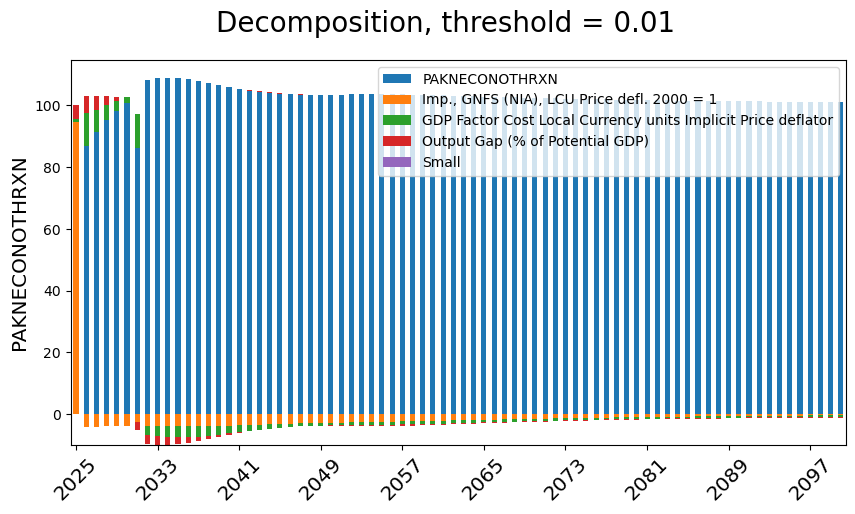

In [20]:
fig=mpak.dekomp_plot('PAKNECONOTHRXN',pct=True,rename=True,threshold=.01,lag=False); #decomp of teh change in the level

:::{index} single: Impact Decomposition; Single equation, charts ,  pct=True/False
:::
:::{index} single: Impact Decomposition; Single equation, charts , rename=True/False
:::
:::{index} single: Impact Decomposition; Single equation, charts , threshold=xx
:::
:::{index} single: Impact Decomposition; Single equation, charts , lag=True/False
:::

In the following example the change in the level of the dependent variable is displayed for a restricted time period.  Here the distinction between the initial impulse (import prices) and the lagged effect of past prices is very evident.

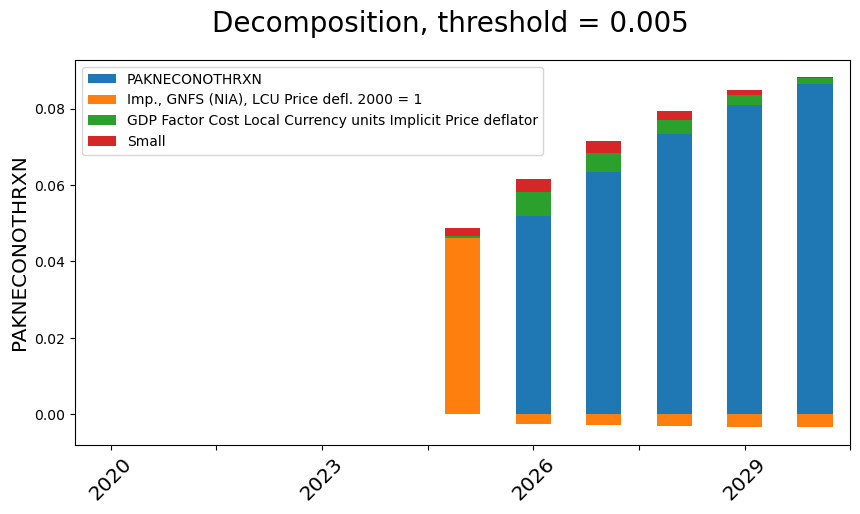

In [21]:
with mpak.set_smpl(2020,2030):
    fig=mpak.dekomp_plot('PAKNECONOTHRXN',pct=False,rename=True,threshold=.005,lag=False); #decomp of teh change in the level

:::{index} single: Impact Decomposition; Single equation, time dimension 
:::



### the time_att option

The above displays focused on the difference between the values in the two dataframes `basedf` and `lastdf`.

By setting he time_att option to True, `get_att()` displays the contribution of changes in the levels of the RHS variables between t and t-1,in explaining the changes in the LHS variable between t and t-1 with all data pulled from the same `.lastdf` datafame.

:::{note}
With the `time_att` option set **only the .lastdf dataframe** is used.   The comparison is not .basedf vs .lastdf but the influence of last year's changes on the level of this year's variable. The attribution is calculated by lagging each right hand side variable one year and recalculating the equation.
:::

In [22]:
mpak.PAKCCEMISCO2TKN .get_att(time_att= True,type='level',bare=0);

,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
Level/level,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Difference,"-46,497,335.17","6,361,989.47","6,744,053.19","6,980,144.51","7,236,796.49","7,475,682.21","7,709,082.86","7,921,378.85","8,105,197.64","8,264,550.49","8,411,112.46","8,557,988.79","8,716,013.72","8,892,516.41","9,091,519.46","9,314,668.95","9,562,200.74","9,833,593.07","10,127,953.28","10,444,143.47","10,780,854.31","11,136,675.37","11,510,178.83","11,900,015.70","12,305,000.63","12,724,167.19","13,156,788.76","13,602,372.59","14,060,639.96","14,531,459.96","15,014,875.21","15,511,017.25","16,020,100.78","16,542,436.62","17,078,365.89","17,628,277.85","18,192,590.44","18,771,753.88","19,366,233.20","19,976,506.90","20,603,062.16","21,246,392.01","21,906,991.14","22,585,366.80","23,282,029.42","23,997,496.26","24,732,302.79","25,486,987.23","26,262,104.42","27,058,225.07","27,875,939.42","28,715,854.55","29,578,598.70","30,464,828.98","31,375,200.32","32,310,416.86","33,271,203.15","34,258,304.75","35,272,491.51","36,314,560.67","37,385,337.42","38,485,673.43","39,616,449.25","40,778,573.45","41,972,984.91","43,200,645.95","44,462,556.47","45,759,744.38","47,093,269.48","48,464,221.18","49,873,723.46","51,322,933.59","52,813,045.15","54,345,283.86","55,920,918.15","57,541,238.83"
Percent,-20.18,3.46,3.55,3.54,3.55,3.54,3.53,3.50,3.46,3.41,3.36,3.30,3.26,3.22,3.19,3.16,3.15,3.14,3.14,3.13,3.14,3.14,3.15,3.16,3.16,3.17,3.18,3.18,3.19,3.20,3.20,3.20,3.20,3.21,3.21,3.21,3.21,3.21,3.21,3.20,3.20,3.20,3.20,3.19,3.19,3.19,3.18,3.18,3.17,3.17,3.17,3.16,3.16,3.15,3.15,3.14,3.14,3.13,3.13,3.12,3.12,3.11,3.10,3.10,3.09,3.09,3.08,3.08,3.07,3.07,3.06,3.06,3.06,3.05,3.05,3.04
t,"183,872,960.05","190,234,949.52","196,979,002.71","203,959,147.22","211,195,943.71","218,671,625.93","226,380,708.78","234,302,087.64","242,407,285.28","250,671,835.77","259,082,948.22","267,640,937.01","276,356,950.74","285,249,467.15","294,340,986.61","303,655,655.56","313,217,856.30","323,051,449.38","333,179,402.66","343,623,546.13","354,404,400.44","365,541,075.82","377,051,254.64","388,951,270.34","401,256,270.98","413,980,438.16","427,137,226.93","440,739,599.51","454,800,239.47","469,331,699.43","484,346,574.64","499,857,591.89","515,877,692.67","532,420,129.30","549,498,495.19","567,126,773.04","585,319,363.47","604,091,117.36","623,457,350.56","643,433,857.45","664,036,919.62","685,283,311.63","707,190,302.76","729,775,669.57","753,057,698.98","777,055,195.24","801,787,498.04","827,274,485.26","853,536,589.69","880,594,814.76","908,470,754.18","937,186,608.72","966,765,207.42","997,230,036.40","1,028,605,236.72","1,060,915,653.58","1,094,186,856.73","1,128,445,161.48","1,163,717,652.99","1,200,032,213.66","1,237,417,551.09","1,275,903,224.52","1,315,519,673.76","1,356,298,247.21","1,398,271,232.12","1,441,471,878.07","1,485,934,434.54","1,531,694,178.92","1,578,787,448.41","1,627,251,669.59","1,677,125,393.05","1,728,448,326.64","1,781,261,371.80","1,835,606,655.66","1,891,527,573.81","1,949,068,812.63"
t-1,"230,370,295.21","183,872,960.05","190,234,949.52","196,979,002.71","203,959,147.22","211,195,943.71","218,671,625.93","226,380,708.78","234,302,087.64","242,407,285.28","250,671,835.77","259,082,948.22","267,640,937.01","276,356,950.74","285,249,467.15","294,340,986.61","303,655,655.56","313,217,856.30","323,051,449.38","333,179,402.66","343,623,546.13","354,404,400.44","365,541,075.82","377,051,254.64","388,951,270.34","401,256,270.98","413,980,438.16","427,137,226.93","440,739,599.51","454,800,239.47","469,331,699.43","484,346,574.64","499,857,591.89","515,877,692.67","532,420,1

In [23]:
help(mpak.get_att)

Help on method get_att in module modelclass:

get_att(n, type='pct', filter=False, lag=True, start='', end='', time_att=False, threshold=0.0) method of modelclass.model instance
    Calculate the attribution percentage for a variable.

    Parameters:
        n (str): Name of the variable to calculate attribution for.
        type (str): Type of attribution calculation. Options: 'pct' (percentage), 'level', 'growth'. Default: 'pct'.
        filter (bool): [Deprecated] Use threshold instead of filter. Default: False.
        lag (bool): Flag to indicate whether to include lag information in the output. Default: True.
        start (str): Start period for calculation. If not provided, uses the first period in the model instance. Default: ''.
        end (str): End period for calculation. If not provided, uses the last period in the model instance. Default: ''.
        time_att (bool): Flag to indicate time attribute calculation. Default: False.
        threshold (float): Threshold value 

In [24]:
help(mpak.dekomp_plot)

Help on method dekomp_plot in module modelclass:

dekomp_plot(varnavn, sort=True, pct=True, per='', top=0.9, threshold=0.0, lag=True, rename=True, nametrans=<function Dekomp_Mixin.<lambda> at 0x000001DEBCCBEDE0>, time_att=False) method of modelclass.model instance
    Returns  a chart with attribution for a variable over the smpl

    Parameters
    ----------
    varnavn : TYPE
        variable name.
    sort : TYPE, optional
        . The default is False.
    pct : TYPE, optional
        display pct contribution . The default is True.
    per : TYPE, optional
        DESCRIPTION. The default is ''.
    threshold : TYPE, optional
        cutoff. The default is 0.0.
    rename : TYPE, optional
        Use descriptions instead of variable names. The default is True.
    time_att : TYPE, optional
        Do time attribution . The default is False.
    lag : TYPE, optional
       separete by lags The default is True.
    top : TYPE, optional
      where to place the title


    Returns
 

:::{index} single: Impact Decomposition; Single Equation, Trace preceding variables 
:::

## Trace and decomposition combined

The `.tracepre()` method can combine the graphical representation of the `tracepre()` method described in the previous chapter and the tabular results from `dekomp()`.  

This is implicit in the standard call to `.tracepre()`where the thickness of the lines is derived from the empirical importance of the changes in each LHS variable in determining the change in the RHS variable.  


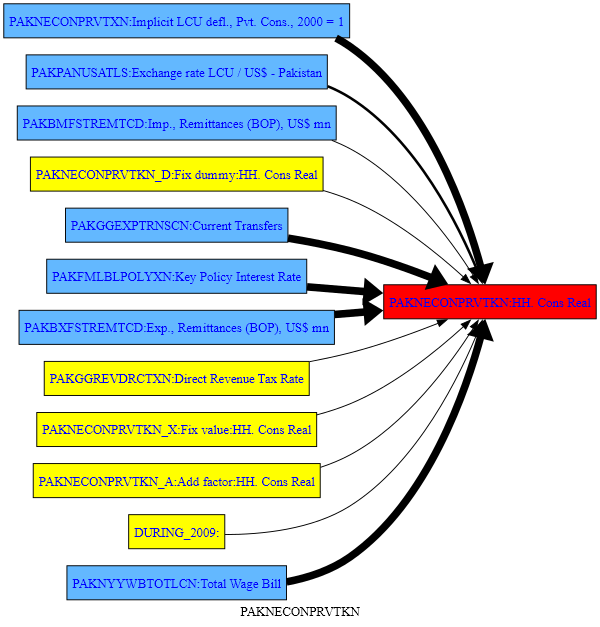

In [25]:
mpak.PAKNECONPRVTKN.tracepre(png=latex,size=(2,4));

## Tabular output from tracepre()

The results for `.tracepre` can be displayed in a number of ways and the results can be saved as pictures. 

|||
|:--|:--|
|**up = xx**|determines how many levels of parents to include|
|**showdata\|sd=True**|Causes the tables of attribution for each displayed variable to be displayed|
|**showdata\|sd=\<'pattern of variable names'>**|will include a table of values for each variable matching the pattern (including wildcharts|
|**attshow\|ats = True**| adds in the contribution of each to the total change|
|**growthshow\|gs = True**| will include a table of growth for each variable|
|**HR = True**| will reorient the dependency graph|
|**filter=\<xx>**|restrict outputs to variables that explain at least xx% of the change in the level of dependent variable |
|**browser = True**|Opens a browser with the resulting dependency graph - useful for zooming on a big graph or table|
|**pgn = True**|will display as a png picture
|**svg = True**|will display as a svg picture which can be zoomed
|**pdf = True**|will display as a pdf picture
|**eps = True**|will create a eps file (a latex format)
|**saveas = \<a file name without extension>**|will save the picture wit the filename with an added extension reflection the picture type     
    

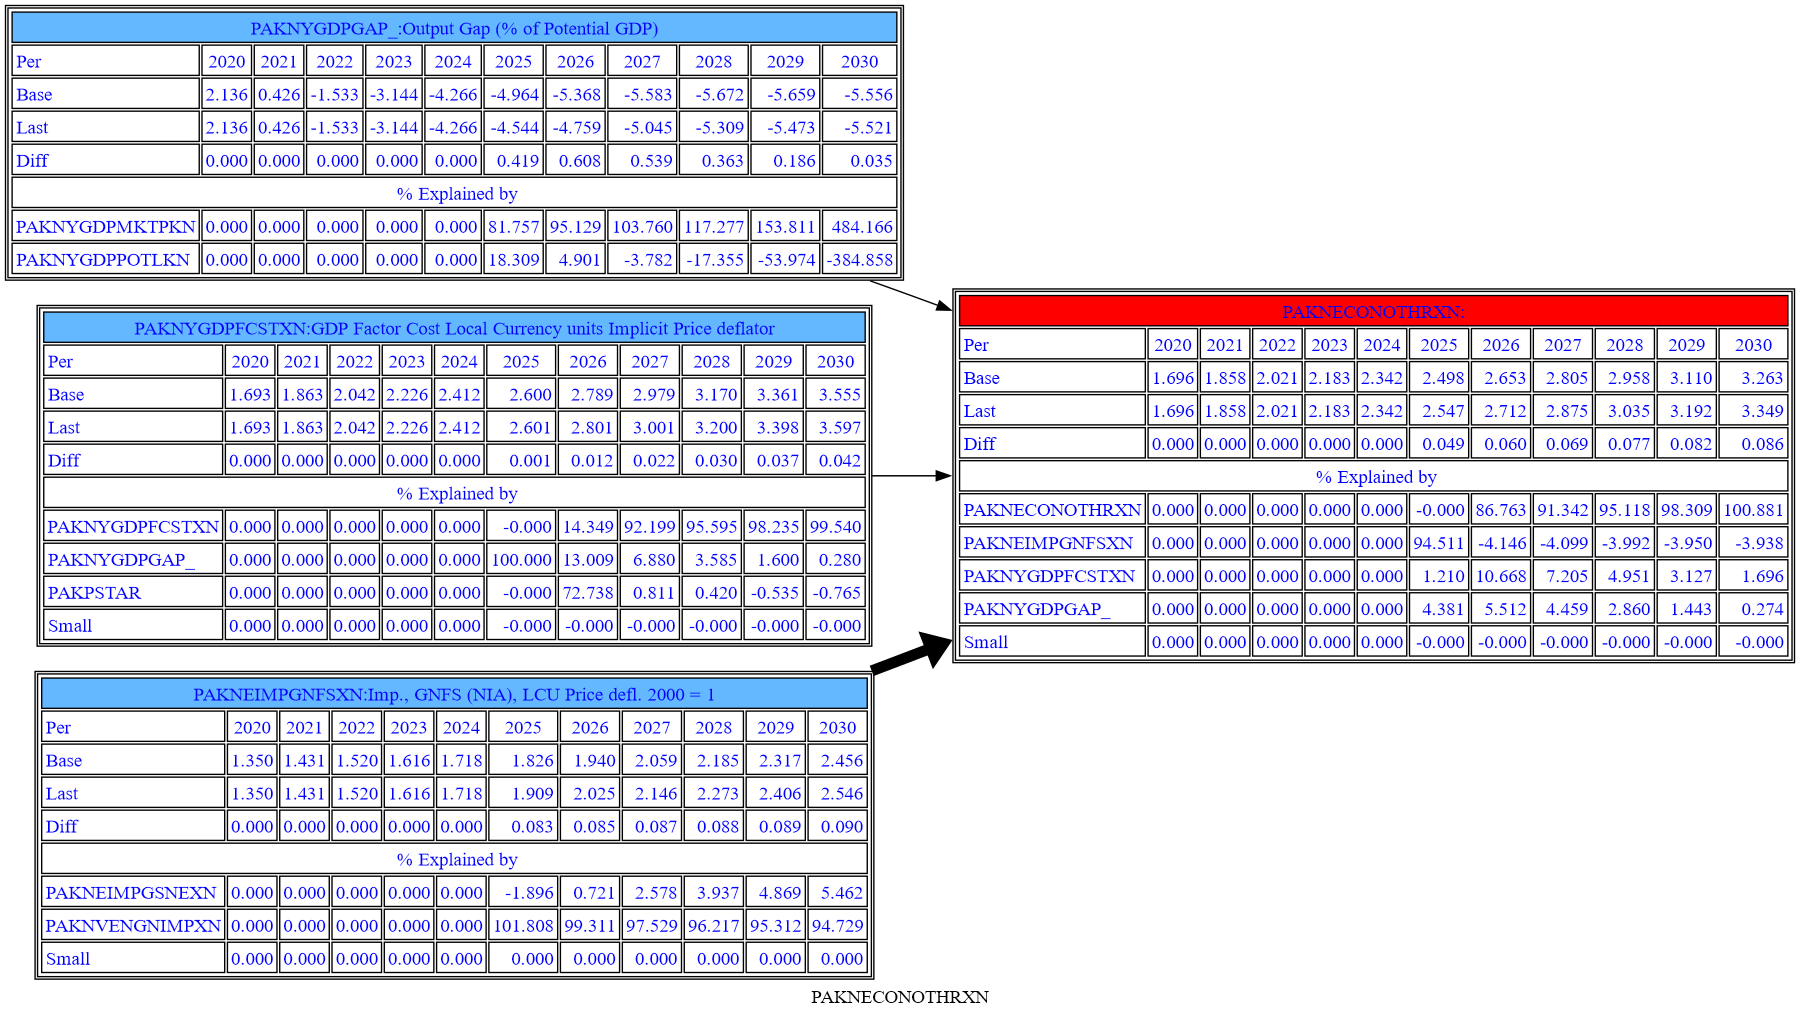

In [26]:
with mpak.set_smpl(2020,2030):
    mpak.PAKNECONOTHRXN.tracepre(filter=5.0,HR=False,showdata= True,attshow=True,per=2020,png=latex)

The big difference with this representation is the contributions of both the direct that directly impact the LHS variable (as well as the influence of those variables one or two steps up the causal chain) can be traced.

Below the same command as above but we specify that we want to go up two levels in the causal chain.

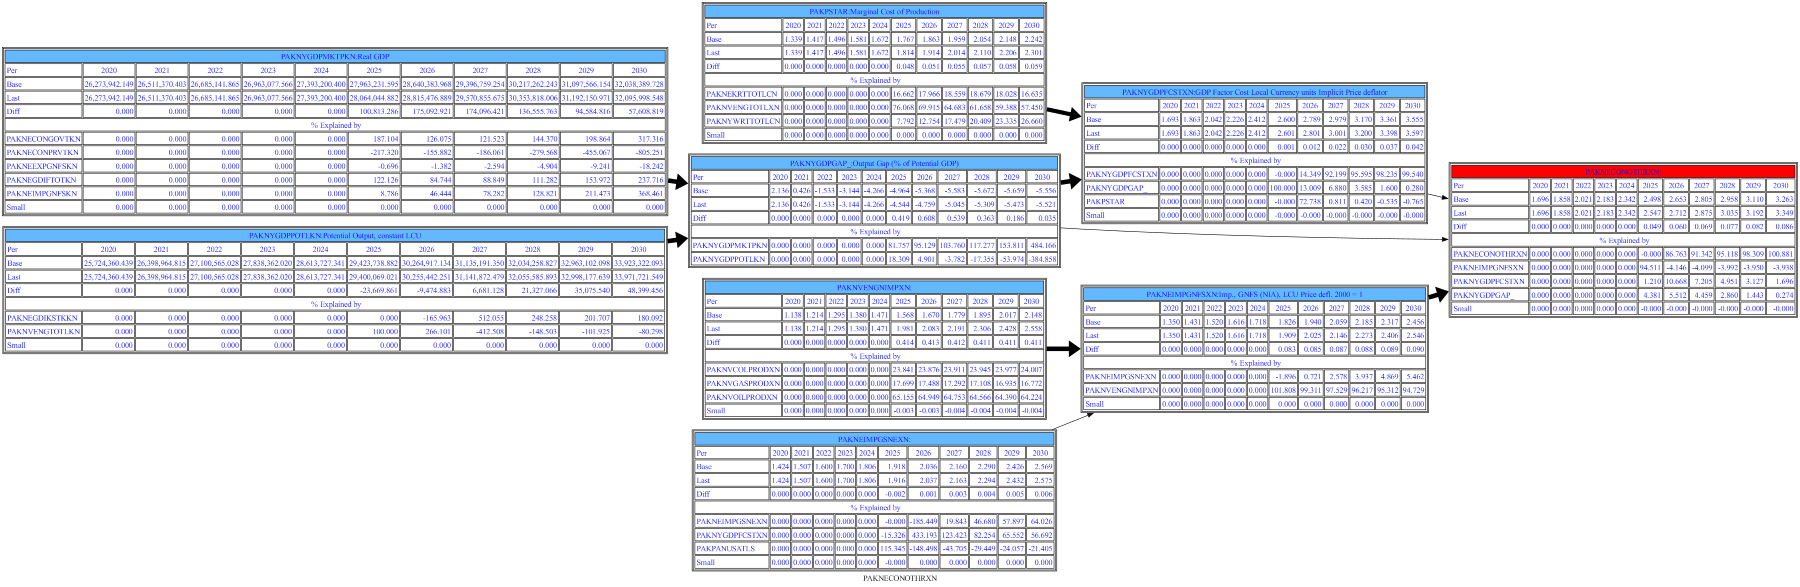

In [27]:
with mpak.set_smpl(2020,2030):
    mpak.PAKNECONOTHRXN.tracepre(up=2,filter=5,HR=False,sd= True,ats=True,png=latex)

In [28]:
with mpak.set_smpl(2020,2023):
    mpak.PAKNECONPRVTKN.tracepre(sd='*lcn',filter=10,HR=1,ats=1,up=2
    ,growthshow=1,png=latex)

No graph PAKNECONPRVTKN
The graph is empty
Perhaps filter prunes to much


As indicated by the error message the filter is too fine, and has eliminated all variables from the output.  Below the same command without the filter option.

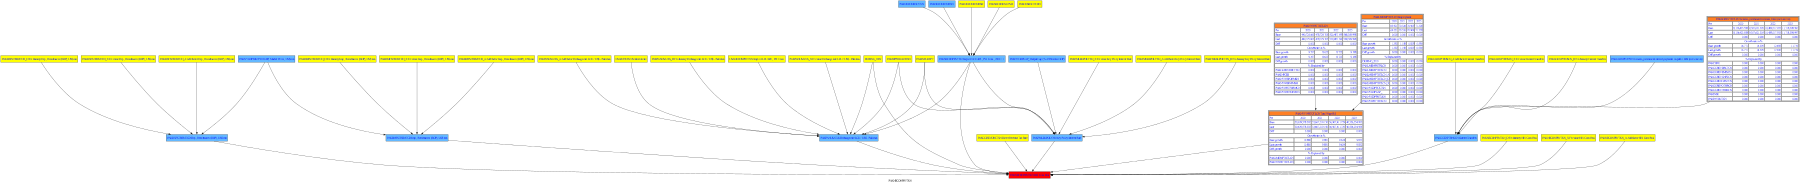

In [29]:
with mpak.set_smpl(2020,2023):
    mpak.PAKNECONPRVTKN.tracepre(sd='*lcn',HR=1,ats=1,up=2
    ,growthshow=1,png=latex)

:::{index} single: Impact Decomposition; Graph over time
:::
:::{index} single: Scenarios; Advanced .tracepre() with graphs over time
:::

## Chart of the contributions over time 

:::{index} single: Impact Decomposition; Single equation, Waterfall graphs
:::

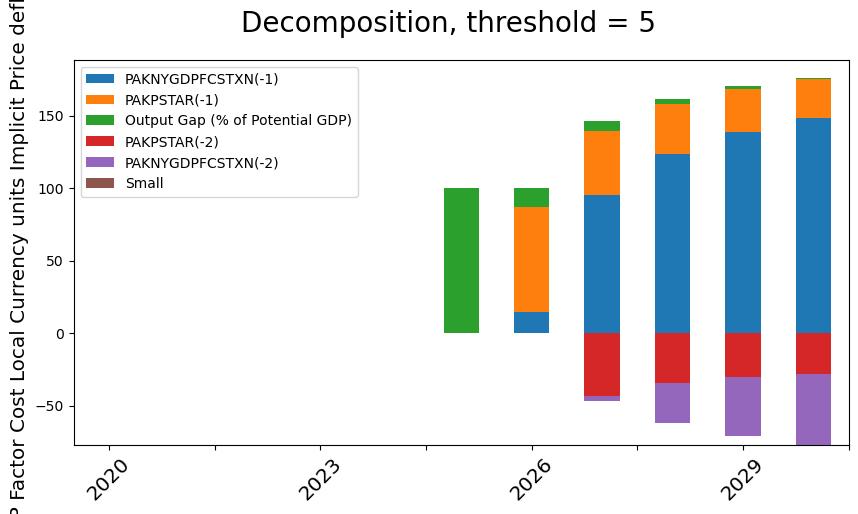

In [30]:


with mpak.set_smpl(2020,2030):
    mpak.dekomp_plot('PAKNYGDPFCSTXN',threshold=5);  # gives a waterfall of contributions

## Chart of the contributions for one year
It can be useful to visualize the attribution as a waterfall chart for a single year

:::{index} single: .dekomp_plot(); per=x option
:::


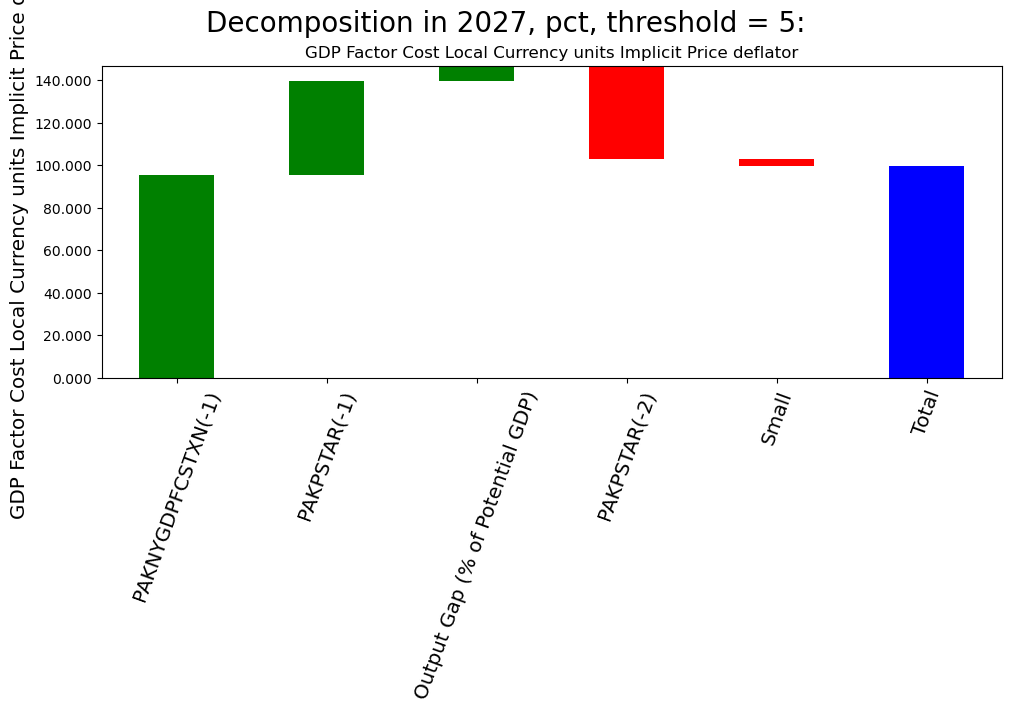

In [31]:
mpak.dekomp_plot_per('PAKNYGDPFCSTXN',per=2027,threshold=5)  # gives a waterfall of contributions

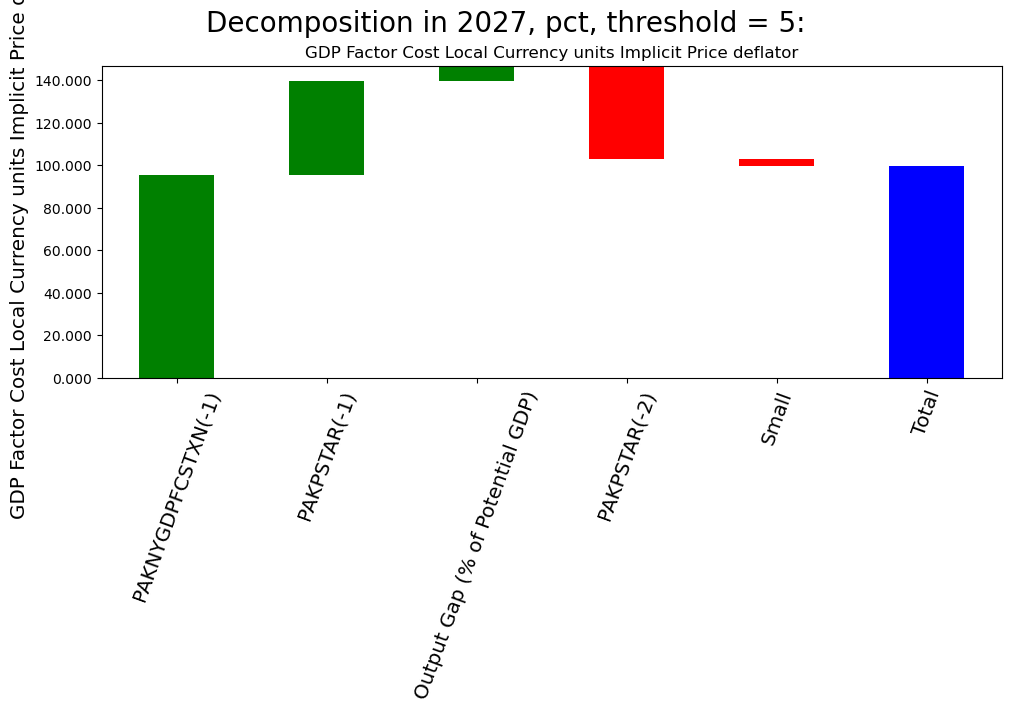

In [32]:
mpak.dekomp_plot_per('PAKNYGDPFCSTXN',per=2027,threshold=5)  # gives a waterfall of contributions

## Sorted waterfall of contributions
:::{index} single: .dekomp_plot(); sort=xx option
:::


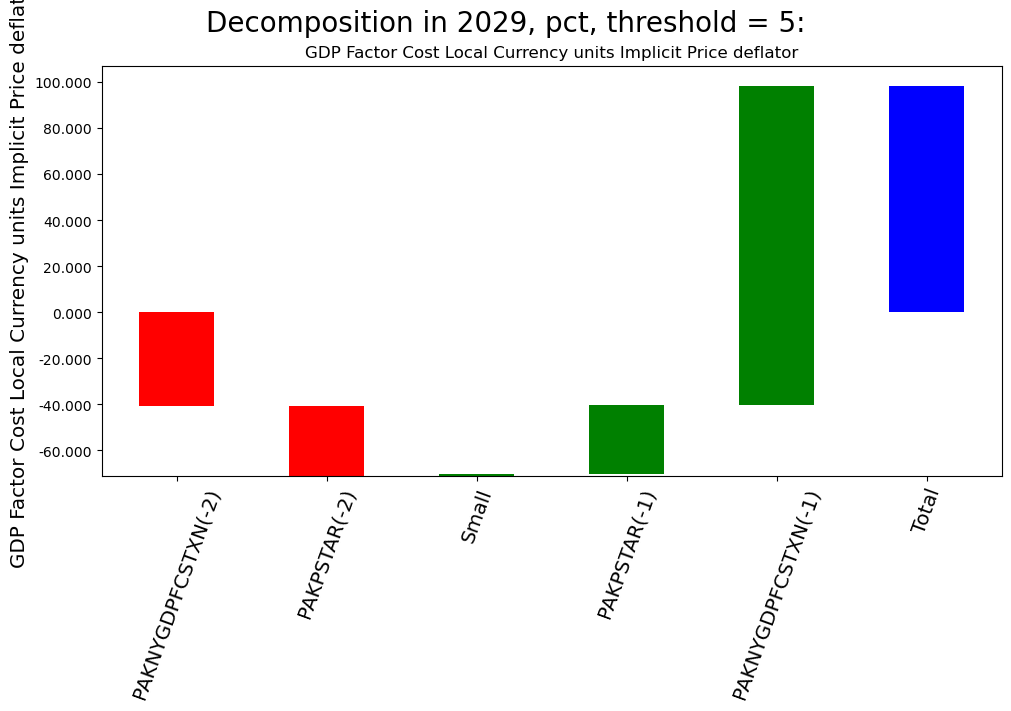

In [33]:
mpak.dekomp_plot_per('PAKNYGDPFCSTXN',per=2029,threshold=5,sort=True)  # gives a waterfall of contributions

:::{index} single: Impact Decomposition; Whole model .totdif() method
:::

:::{index} single: Impact Decomposition; Find all exogenous shocks .exodif() method
:::


## Impacts at the model level: the `.totdif()` method 

The method `.totdif()` returns an instance of the totdif class, which provides a number of methods and properties to explore decomposition at the model level.

It works by solving the model numerous times, each time changing one of the right hand side variables and calculating the impact on all dependent variables. By default it uses the values from the `.lastdf` `DataFrame` as the shock values and the values in `.basedf` as the initial values. Separate simulations are run for every exogenous (or exogenized) variables that have changed between the two `DataFrame`s. 

For advanced users the RHS variables can be grouped into user defined blocks, which in cases where there are many changes can help identify the main causal pathways.

### The `.exo_dif()` method 
The `.exodif()` method displays only the exogenous variables that have changed between the two `DataFrame`s (the shock). Exogenous variables whose results have not changed are omitted. It determines which of the exogenous variables have changed between `.lastdf`and `.basedf` and then returns a `DataFrame` with the changes in the values. 

In this case the `DataFrame` contains the the effect of updating the $CO^2$ tax to 30 for coal, gas and oil. `.exo_dif()` is automatically called by the `.totdif()` method but can also be called directly b y the user. 

In [34]:
mpak.exodif()

,PAKGGREVCO2CER,PAKGGREVCO2GER,PAKGGREVCO2OER
2020,35.55,71.0,38.71
2021,35.55,71.0,38.71
2022,35.55,71.0,38.71
2023,35.55,71.0,38.71
2024,35.55,71.0,38.71
...,...,...,...
2096,35.55,71.0,38.71
2097,35.55,71.0,38.71
2098,35.55,71.0,38.71
2099,35.55,71.0,38.71


### The `.totdif()` command calculates the contribution of each changed variable to the changes in a specified LHS variable
This involves solving the model a number of times, so can take some time. How long it takes to execute will depend on the computer, the model and the number of changes made.  In this instance the `.totaldif` takes between 2 and 5 seconds depending on computer. 

In [35]:
totdekomp = mpak.totdif() # Calculate the total derivative½s of all equations in the model.

Total dekomp took       :         5.394 Seconds


:::{index} single: Scenarios; .explain_all() method Total differential graph 
:::
:::{index} Total differential graph .explain_all() method
:::
:::{index} single: Impact Decomposition; .explain_all() method Total differential graph 
:::
:::{index} single: Impact Decomposition; Total differential graph .explain_all() method
:::

### The method `.explain_all()` presents the results graphically

In the example below, the relative importance of the three shocked carbon taxes on the change in real GDP are presented.

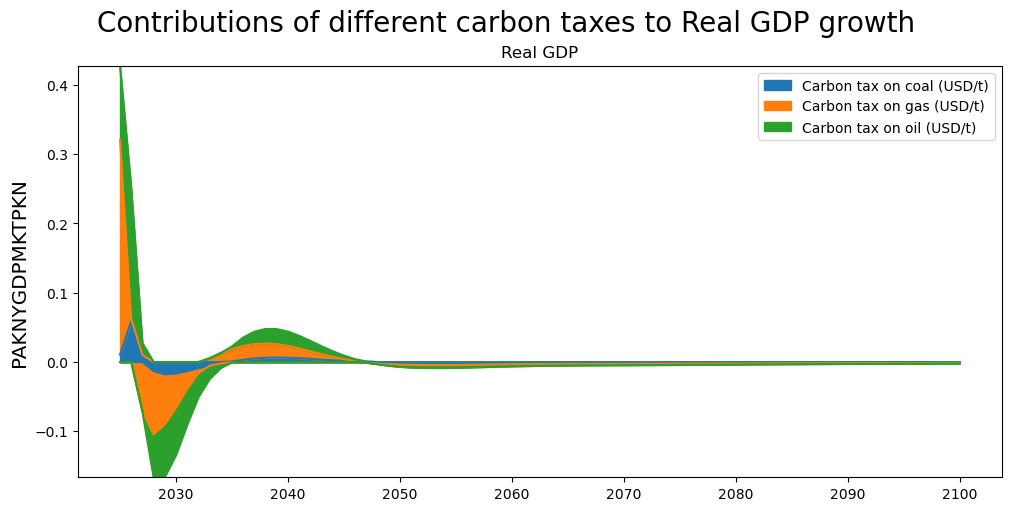

In [36]:
showvar = 'PAKNYGDPMKTPKN'
totdekomp.explain_all(showvar,kind='area',use='growth',stacked=True,
                      title="Contributions of different carbon taxes to Real GDP growth") ;

In [37]:
help(totdekomp.explain_all)

Help on method explain_all in module modeldekom:

explain_all(pat='', stacked=True, kind='bar', top=0.9, title='', use='level', threshold=0.0, resample='', axvline=None) method of modeldekom.totdif instance
    Explains all

    Args:
        pat (TYPE, optional): DESCRIPTION. Defaults to ''.
        stacked (TYPE, optional): DESCRIPTION. Defaults to True.
        kind (TYPE, optional): DESCRIPTION. Defaults to 'bar'.
        top (TYPE, optional): DESCRIPTION. Defaults to 0.9.
        title (TYPE, optional): DESCRIPTION. Defaults to ''.
        use (TYPE, optional): DESCRIPTION. Defaults to 'level'.
        threshold (TYPE, optional): DESCRIPTION. Defaults to 0.0.
        resample (TYPE, optional): DESCRIPTION. Defaults to ''.
        axvline (TYPE, optional): DESCRIPTION. Defaults to None.

    Returns:
        None.



### Many variables

If many variables are passed to explain_all then separate graphs will be created for each.

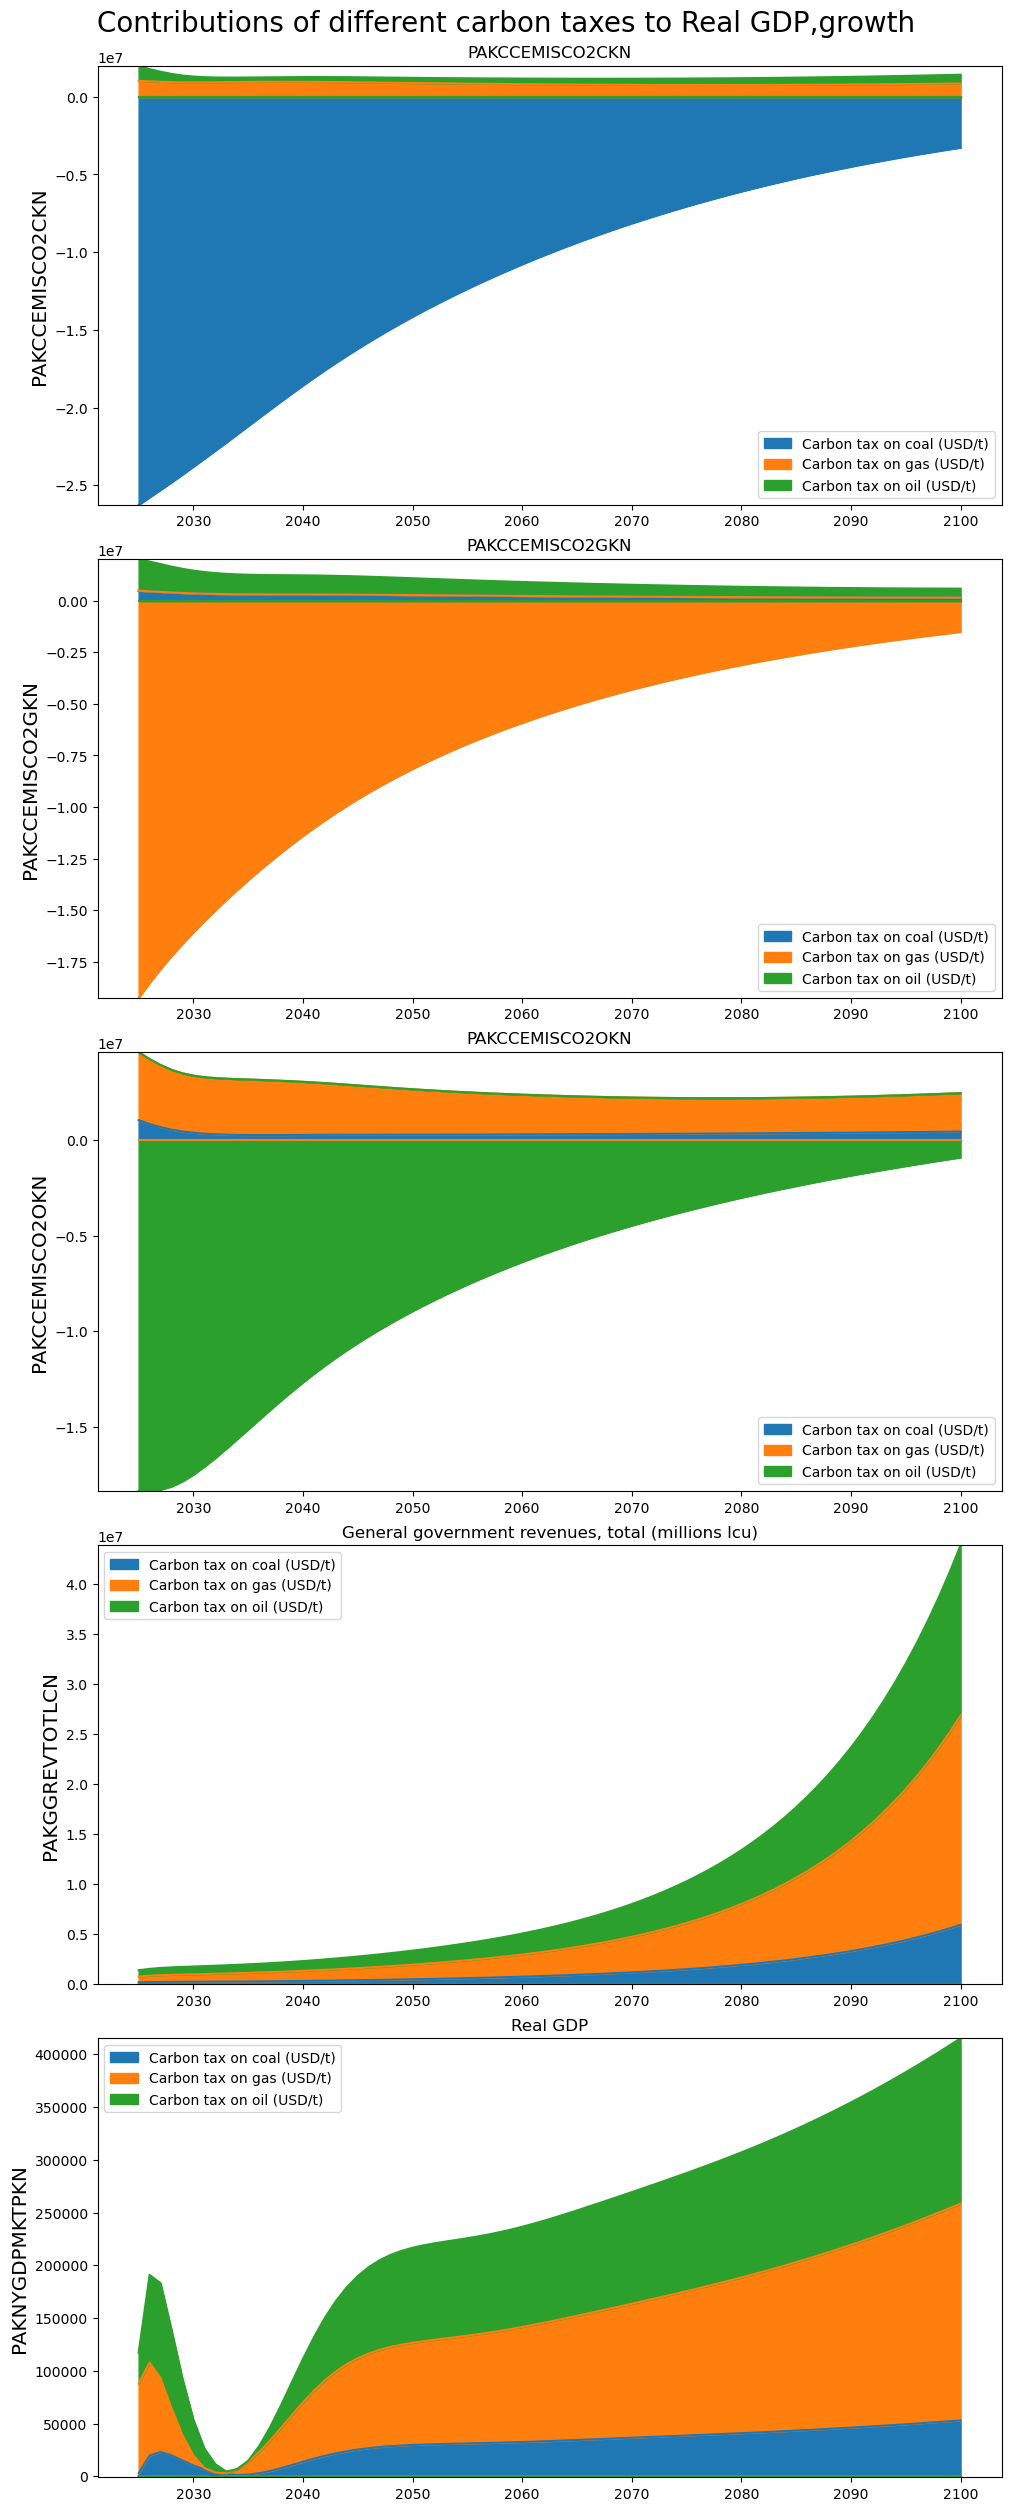

In [38]:
showvar = 'PAKNYGDPMKTPKN PAKCCEMISCO2CKN PAKCCEMISCO2OKN PAKCCEMISCO2GKN PAKGGREVTOTLCN'

totdekomp.explain_all(showvar,kind='area',stacked=True,title="Contributions of different carbon taxes to Real GDP,growth") ;


:::{index} single: Impact Decomposition; Total differential for specific period
:::
:::{index} single: Impact Decomposition; .explain_per()
:::

### Similarly the impacts on different variables for one year can be shown

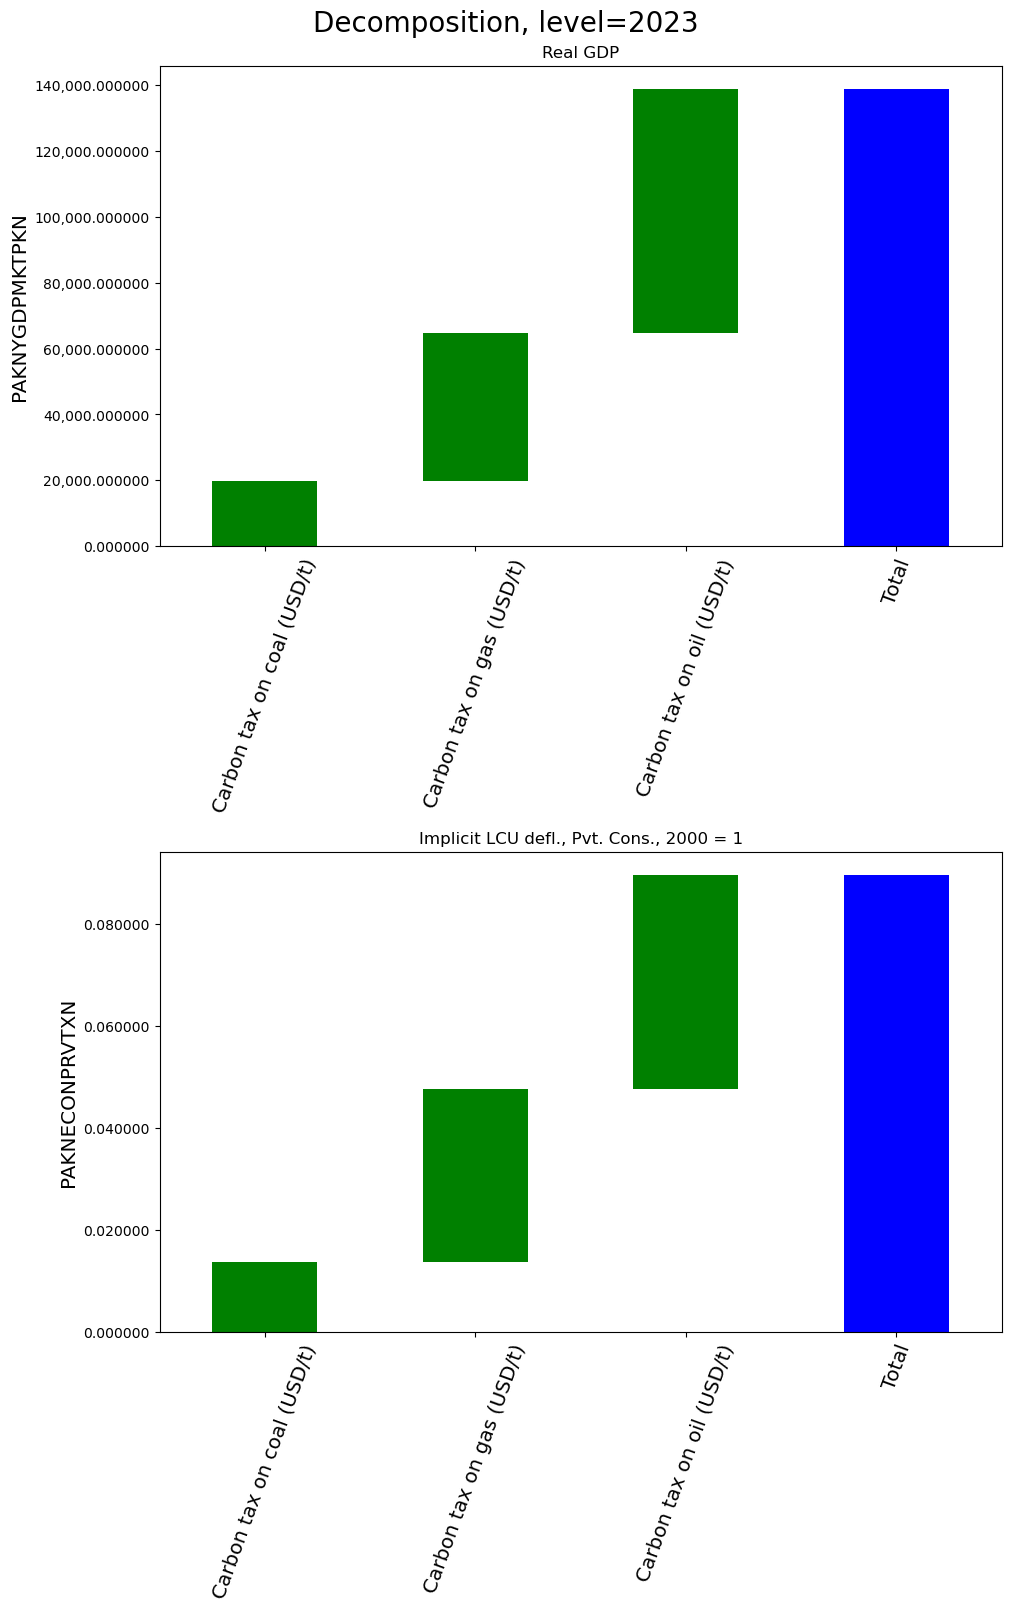

In [39]:
showvar = 'PAKNYGDPMKTPKN PAKNECONPRVTXN'

totdekomp.explain_per(showvar,per=2028,ysize=8,title='Decomposition, level=2023')

:::{index} single: Scenarios; Impact decomposition interactive widget
:::
:::{index} single: Scenarios; .get_att_gui() method
:::
:::{index} single: Impact Decomposition; .get_att_gui() interactive widget
:::



### Or an interactive widgets can be generated
This allows the user to select the specific variable of interest and what to display: 


:::{note}
If this is read in a manual the widget is not live. 

In a notebook the selection widgets are live. 
:::


In [79]:
display(mpak.get_att_gui(var='PAKGGREVTOTLCN',ysize=7));

interactive(children=(Dropdown(description='Variable', index=108, options=('CHNEXR05', 'CHNPCEXN05', 'DEUEXR05…

None

:::{index} single: Scenarios; Impact decomposition of the last year
:::
:::{index} single: Scenarios; .explain_last()
:::
:::{index} single: Impact Decomposition; .explain_last() of the last year
:::

### Decomposition of the last year 

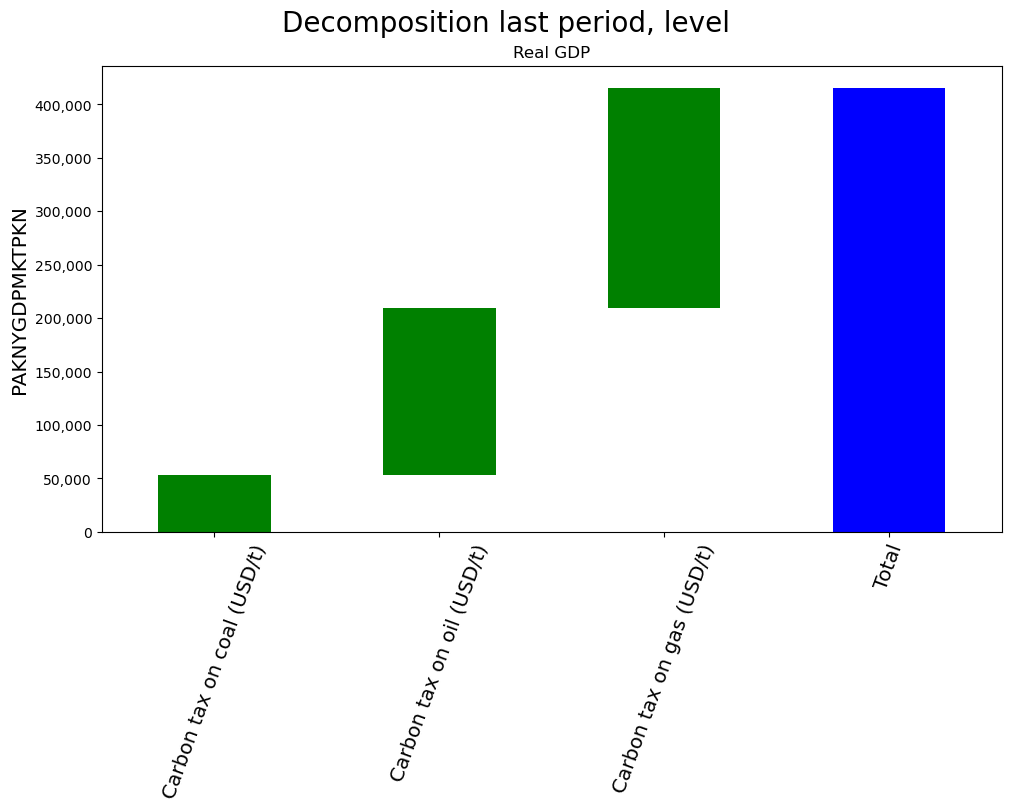

In [71]:
showvar = 'PAKNYGDPMKTPKN'
totdekomp.explain_last(showvar,ysize=8,title='Decomposition last period, level')

:::{index} single:Impact Decomposition; .explain_sum()  accumulated effects
:::
:::{index} single:Scenarios; Impact decomposition summed over all years
:::

### Decomposition of accumulated effects 

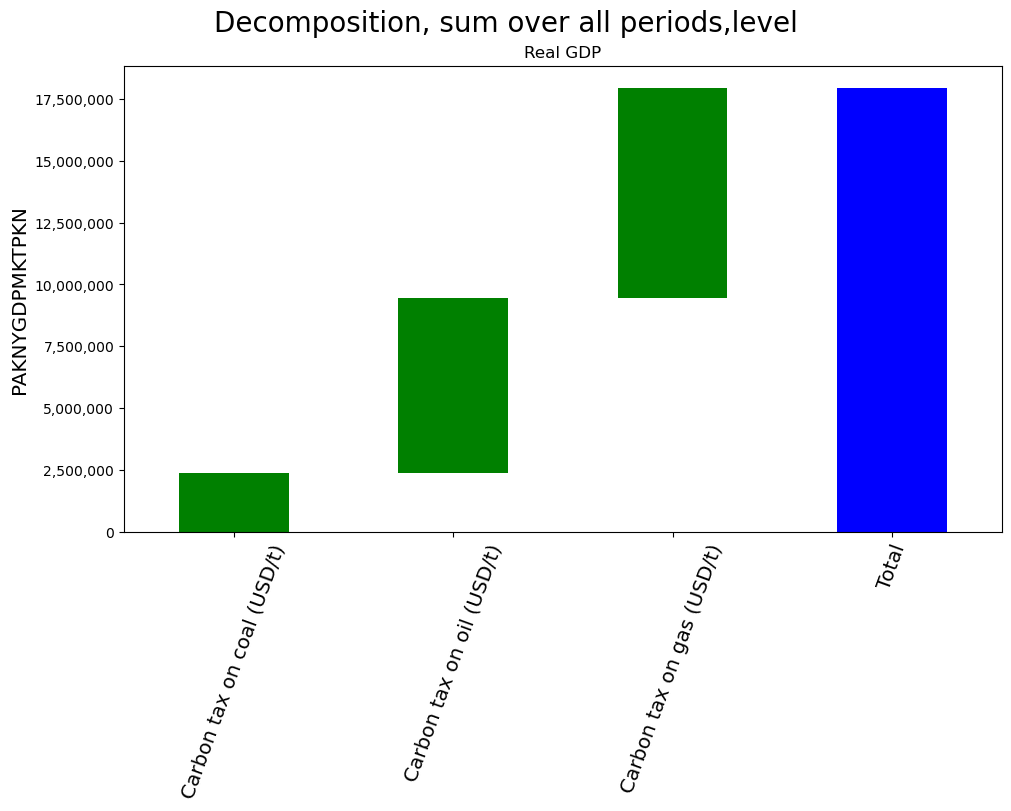

In [73]:
totdekomp.explain_sum(showvar,ysize=8,title="Decomposition, sum over all periods,level")

## More advanced model attribution

For some  simulations the number of changed exogenous variables can be large. Using a dictionary to contain the experiments allows us to manage multiple scenarios and multiple outputs. 

Using this approach, if there are many simulations, data can be filtered in order to look only at the variables with an impact above a certain threshold. 



:::{index} single: Scenarios; Total differential grouping variables
:::
:::{index} single: Impact Decomposition; .dekomp() option Lag=True
:::
:::{index} single:  Impact Decomposition; Total differential grouping variables
:::

### Grouping variables
If many exogenous variables were shocked, exploring impacts may be made easier by aggregating the impacts of some groups or sub-groups of variables. Grouping  variables allows the user to explore the results in a more flexible way slicing and dicing the impact along different dimensions. 

In the example below, the impacts of changing the carbon tax on gas and oil tax are grouped together (aggregated) and the impact of the coal tax is displayed separately. 

In [43]:
shocks = {'gas and Oil':['PAKGGREVCO2OER', 'PAKGGREVCO2GER'],'Coal':['PAKGGREVCO2CER']}
totdekomp_group = mpak.totdif(experiments = shocks) # Calculate the total derivative½s of all equations in the model.

Total dekomp took       :         3.770 Seconds


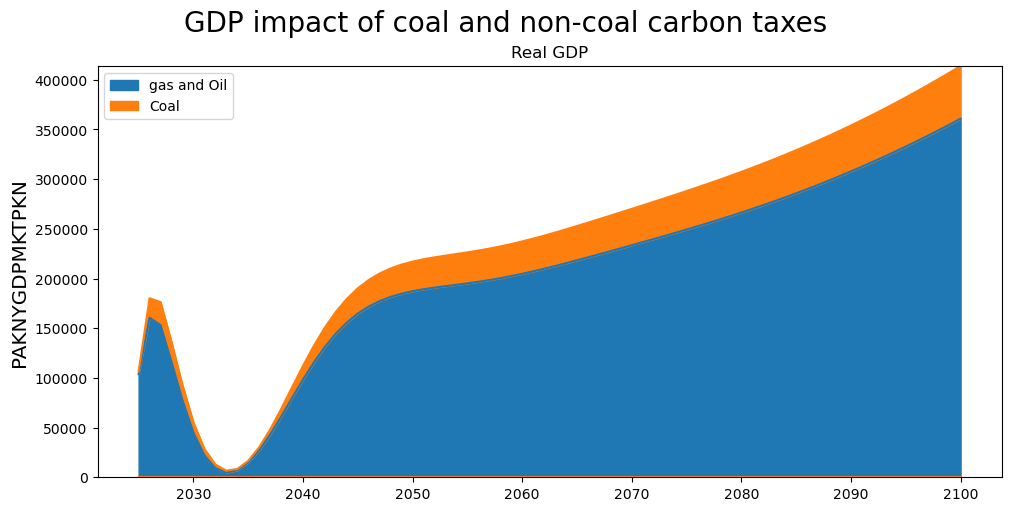

In [44]:
showvar = 'PAKNYGDPMKTPKN'
totdekomp_group.explain_all(showvar,kind='area',stacked=True,title='GDP impact of coal and non-coal carbon taxes');    

While this is a fairly simple example, the grouping mechanism allows us to focus our attention on one factor (the coal price in this instance).  

Here, even though the coal tax was increased by the most (in the baseline it was subsidized), it had a relatively small share in total energy production, so its GDP impact was relatively small.

### Single equation attribution chart 
The results can be visualized in different ways. 

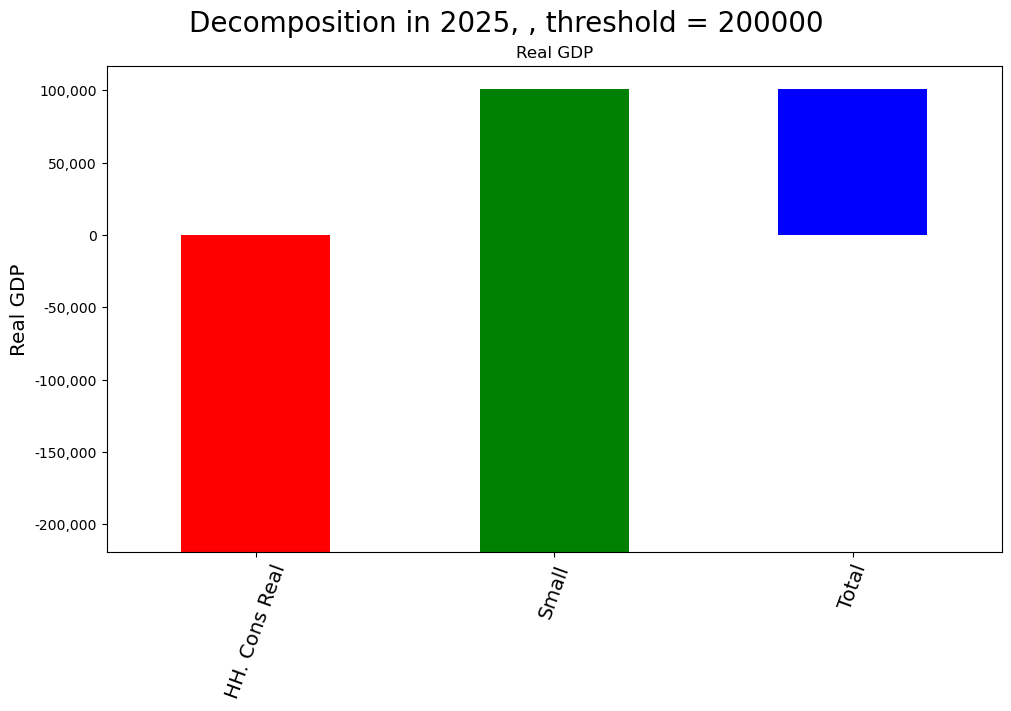

In [77]:
mpak.dekomp_plot_per('PAKNYGDPMKTPKN',
                     per=2025,           # Period to be displayed
                     pct=False,          # Do not show differences as percent changes
                     rename=True,        # Use the long-form vs mnemonic description of variable
                     sort=True,          # 
                     threshold =200000,
                     ysize=7            # Size of y axis in inches   
                     )

### Decomposition of changes over time 

:::{index} single: Quantfiying impacts over time; Influence of  
:::
A classic query is to understand what is driving changes over time.  The `time_att=True` option quantifies the impact of changes over time in the LHS variables on changes in the dependent variable over time using data from the `lastdf` `DataFrame`.  


In [78]:
with mpak.set_smpl(2020,2024):
    mpak['PAKNYGDPMKTPKN'].dekomp(time_att=True)


Formula        : FRML <IDENT> PAKNYGDPMKTPKN = PAKNECONPRVTKN+PAKNECONGOVTKN+PAKNEGDIFTOTKN+PAKNEGDISTKBKN+PAKNEEXPGNFSKN-PAKNEIMPGNFSKN+PAKNYGDPDISCKN+PAKADAP*PAKDISPREPKN $ 

                      2020        2021        2022        2023        2024
Variable   lag                                                            
t-1        0   25760579.31 26273942.15 26511370.40 26685141.86 26963077.57
t          0   26273942.15 26511370.40 26685141.86 26963077.57 27393200.40
Difference 0     513362.84   237428.25   173771.46   277935.70   430122.83
Percent    0          1.99        0.90        0.66        1.04        1.60

 Contributions to differende for  PAKNYGDPMKTPKN
                         2020       2021       2022       2023       2024
Variable       lag                                                       
PAKNECONPRVTKN 0    654250.08  299926.98  191312.66  263735.03  390661.45
PAKNECONGOVTKN 0     67306.61   30293.59   26781.39   52462.03   84392.12
PAKNEGDIFTOTKN 0     60338

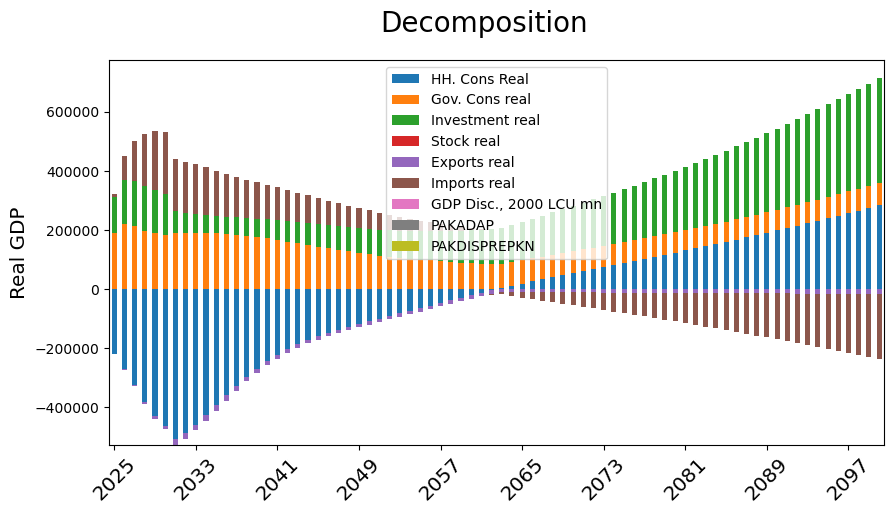

In [47]:
mpak.dekomp_plot('PAKNYGDPMKTPKN',pct=0,rename=1,sort=1,threshold =0,time_att = True);